# Classical approach to speech recognition
In this notebook I present a simple example of classical approach to speech recognition. The method involves computing Dynamic Time Warping (DTW) distance of Mel-frequency cepstral coefficients (MFCCs). The database consists of 13 words in polish, pronounced by a single speaker.

The project uses:
* [DTW for python](https://github.com/pierre-rouanet/dtw)
* [SciPy](https://www.scipy.org/)
* [LibROSA](https://librosa.github.io/librosa/)

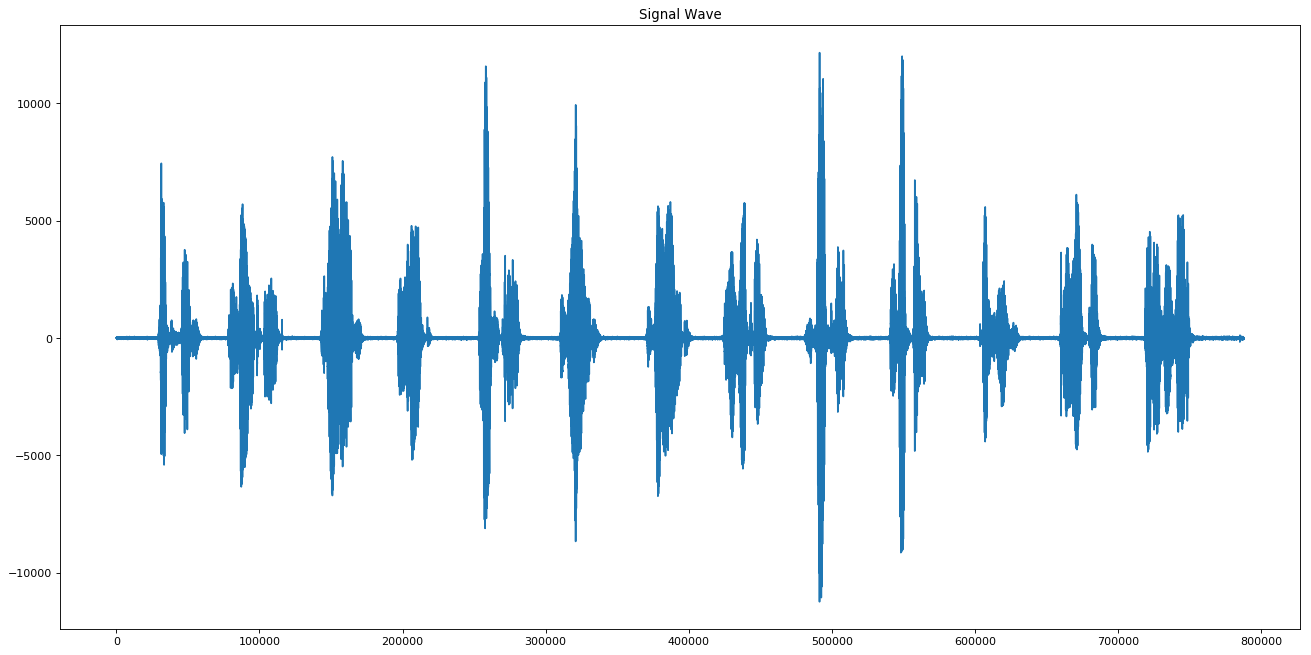

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import agh_util
import scipy.io.wavfile
import scipy.signal
import os
import librosa.util

# Firstly, establish all necessary variables
path = 'sound_data'
words_structure = dict()

#Extract Raw Audio from Wav File (just make a reading function test)
#Expecting 44100 Hz sampling frequency
signal, fs = agh_util.get_signal_from_file('sound_data/273352_23_M_00_3.wav')

timestamps = agh_util.parse_timestamps('sound_data/273352_23_M_00_3.txt')

# Hopefully this is going to be useful later
words_list = [stamp[2] for stamp in timestamps]

plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Signal Wave')

plt.plot(signal)
plt.show()

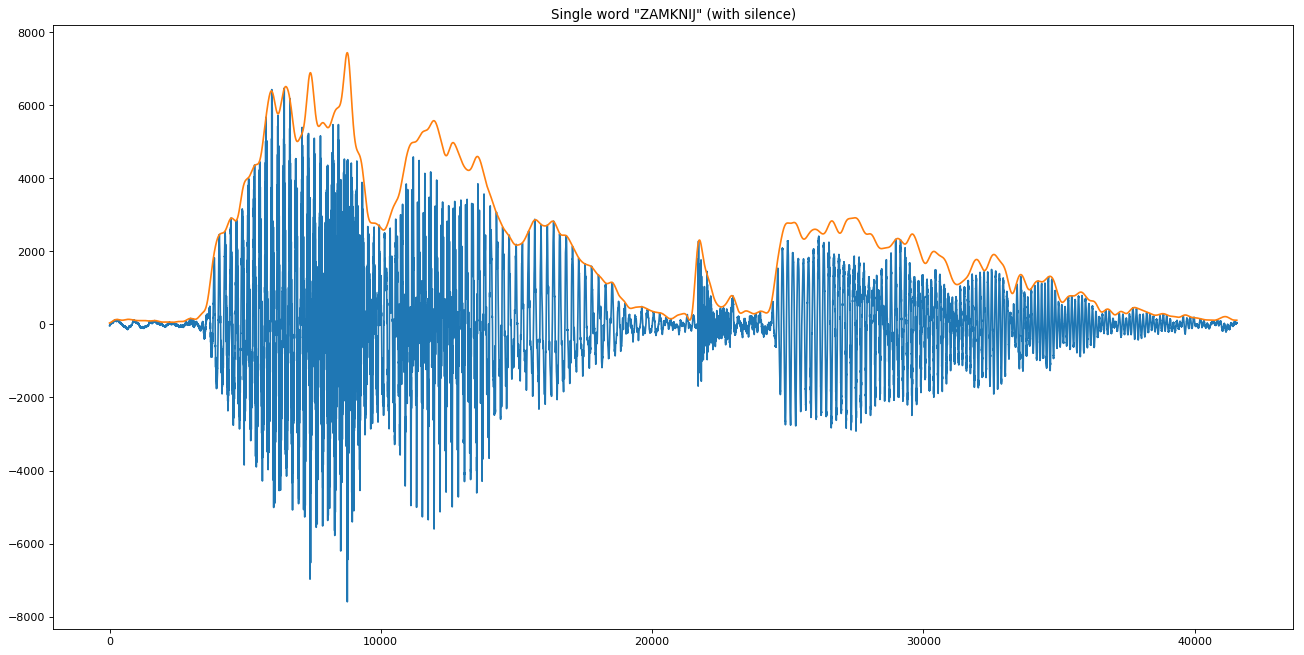

In [2]:
#Having the directory...
for filename in os.listdir(path):
    #...we extract all of the filenames with *.wav extension...
    if(filename.endswith('.wav')):
        #...Then we extract signalfrom files, one by one,
        words_signal, fs = agh_util.get_signal_from_file(path + '/' + filename)
        #use provided timestamps to localize words in signals,
        words_timestamps = agh_util.parse_timestamps(path + '/' + filename.replace('.wav', '.txt'))
        for word_info in words_timestamps:
            #initialize a list...
            if word_info[2] not in words_structure:
                words_structure[word_info[2]] = list()
            #... and put our words into it
            words_structure[word_info[2]].append(words_signal[int(word_info[0]*fs):int(word_info[1]*fs)])


single_word = words_structure['ZAMKNIJ'][0]
env = agh_util.get_envelope(single_word, interval_length = 220, f_s = fs, f_cut = 220)

plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Single word "ZAMKNIJ" (with silence)')
plt.plot(single_word)
plt.plot(env)

plt.show()

# single_word = agh_util.cut_silence(single_word, silence_level = 0.015, envelope = env)
# env = agh_util.get_envelope(single_word, interval_length = 220, f_s = fs, f_cut = 220)
# plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
# plt.title('Single word "ZAMKNIJ" (silence cut out)')
# plt.plot(single_word)
# plt.plot(env)

# plt.show()

In [3]:
#Cut the silence out of each word. Normalize.
for key in words_structure:
    a = list()
    for word in words_structure[key]:
        envel = agh_util.get_envelope(word, interval_length = 220, f_s = fs, f_cut = 220)
        word = word.astype(float)
        word = agh_util.RMS_normalization(agh_util.cut_silence(word, silence_level = 0.02, envelope = envel))
        a.append(word)
    words_structure[key] = a

#check data consistency just in case
#for key in words_structure:
#    print(len(words_structure[key]),'\t', key)

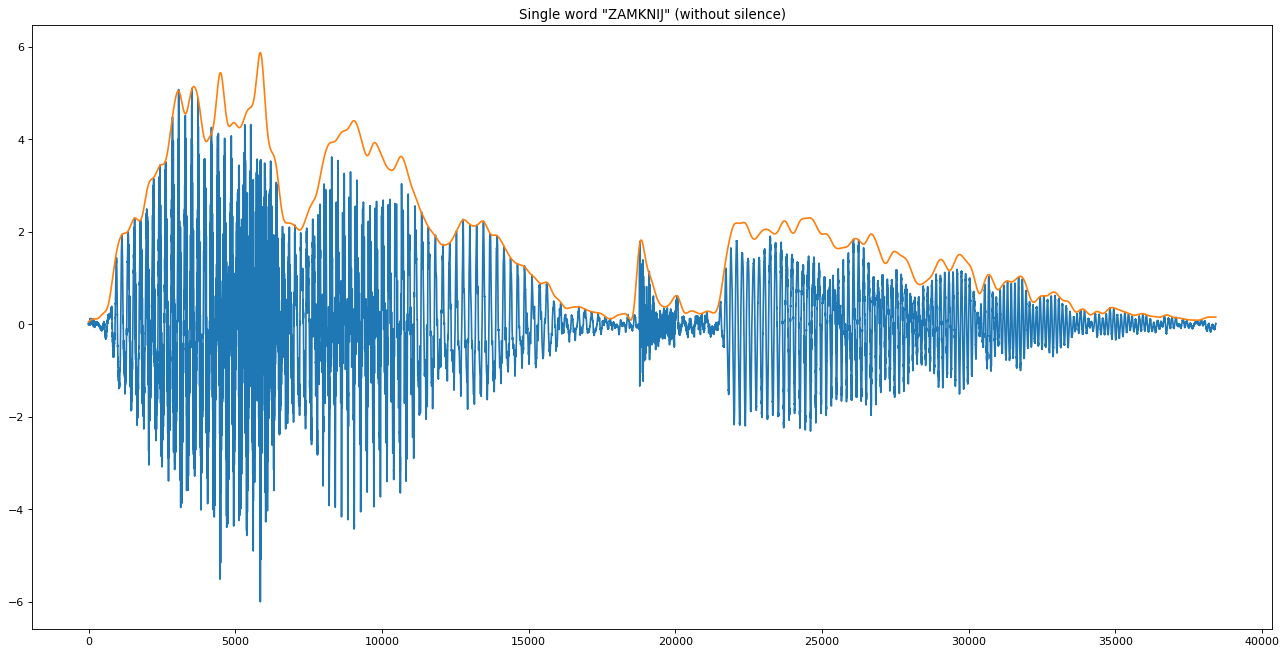

In [4]:
single_word = words_structure['ZAMKNIJ'][0]
env = agh_util.get_envelope(single_word, interval_length = 220, f_s = fs, f_cut = 220)
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Single word "ZAMKNIJ" (without silence)')
plt.plot(single_word)
plt.plot(env)
plt.show()

Normalized distance between the two SAME words: 78.6728447863753


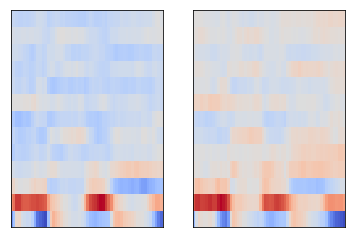

In [5]:
from dtw import dtw
import librosa
import librosa.display

F1 = librosa.feature.mfcc(words_structure['OTWORZ'][0].astype(float), fs, n_mfcc = 13)
plt.subplot(1, 2, 1)
librosa.display.specshow(F1)
F2 = librosa.feature.mfcc(words_structure['OTWORZ'][1].astype(float), fs, n_mfcc = 13)
plt.subplot(1, 2, 2)
librosa.display.specshow(F2)

dist, cost, acc_cost, path = dtw(F1.T, F2.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Normalized distance between the two SAME words:', dist)

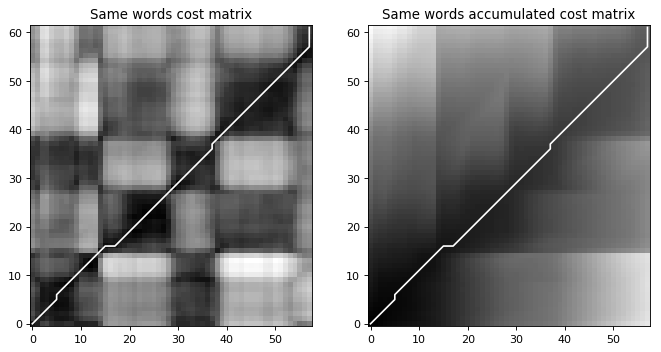

In [6]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.title('Same words cost matrix')
plt.imshow(cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))

plt.subplot(1, 2, 2)
plt.title('Same words accumulated cost matrix')
plt.imshow(acc_cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc_cost.shape[0]-0.5))
plt.ylim((-0.5, acc_cost.shape[1]-0.5))
plt.show()


Normalized distance between two DIFFERENT words: 164.3158376519342


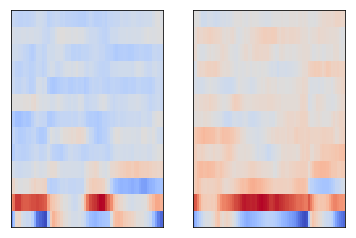

In [7]:
F1 = librosa.feature.mfcc(words_structure['OTWORZ'][0].astype(float), fs, n_mfcc = 13)
plt.subplot(1, 2, 1)
librosa.display.specshow(F1)
F2 = librosa.feature.mfcc(words_structure['WYLACZ'][0].astype(float), fs, n_mfcc = 13)
plt.subplot(1, 2, 2)
librosa.display.specshow(F2)

dist, cost, acc_cost, path = dtw(F1.T, F2.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Normalized distance between two DIFFERENT words:', dist)

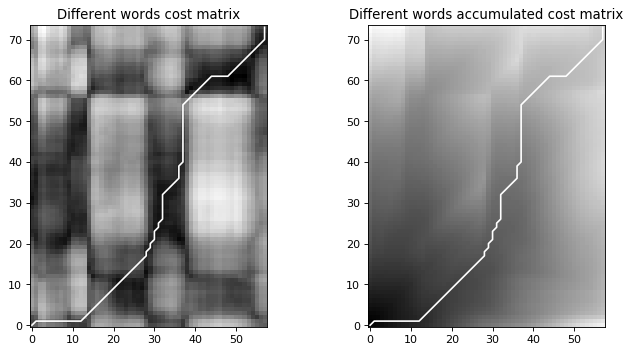

In [8]:
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.title('Different words cost matrix')
plt.imshow(cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))

plt.subplot(1, 2, 2)
plt.title('Different words accumulated cost matrix')
plt.imshow(acc_cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc_cost.shape[0]-0.5))
plt.ylim((-0.5, acc_cost.shape[1]-0.5))
plt.show()



In [9]:
# in https://github.com/pierre-rouanet/dtw/blob/master/examples/speech-recognition.ipynb
# a MFCC distance is taken to determine if the words are the same. Let's take a similar approach for now...

result = dict(words_structure)

# this thing is computationally expensive
for key2 in words_list:
    for word2 in words_structure[key2]:
        a = np.ndarray(shape = len(words_structure[key2]))
        i=0
        for word1 in words_structure['OTWORZ']:
            F1 = librosa.feature.mfcc(word1, fs, n_mfcc = 13)
            F2 = librosa.feature.mfcc(word2, fs, n_mfcc = 13)
            dist, _, _, _ = dtw(F1.T, F2.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
            a[i]=dist
            i=i+1
    result[key2] = a

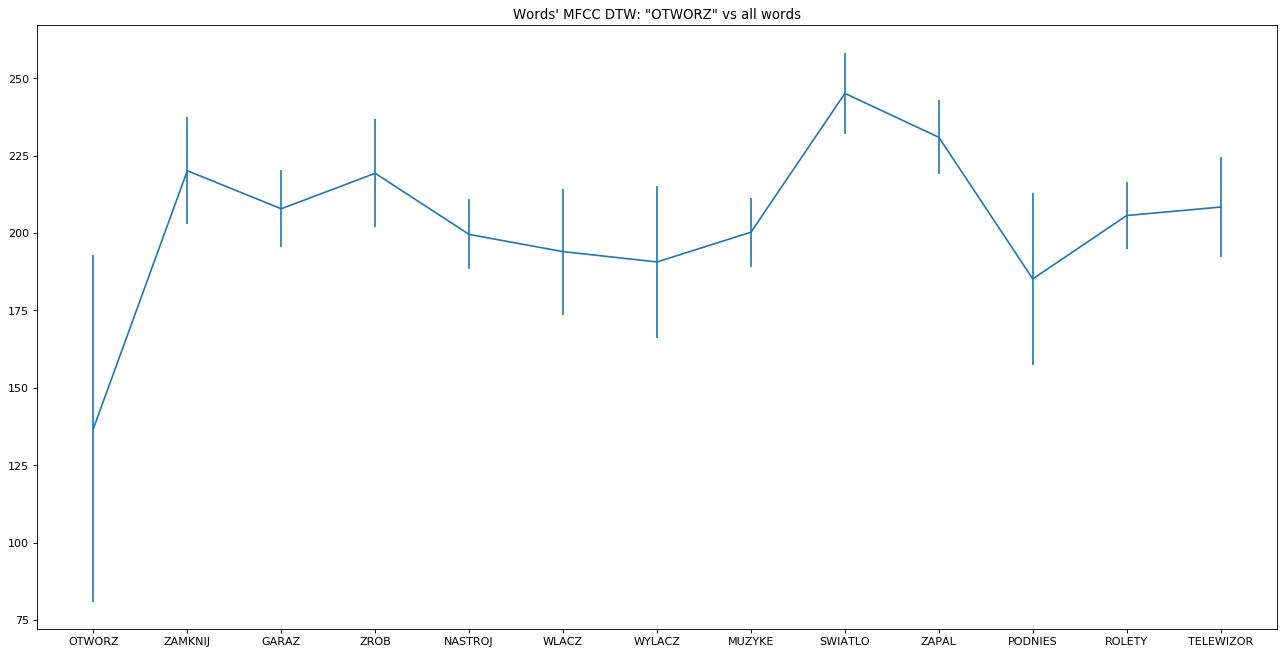

In [10]:
X_axis = range(len(result))

plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.errorbar(X_axis, list(y.mean() for y in result.values()), yerr = list(y.std() for y in result.values()))
plt.xticks(X_axis, list(result.keys()))
plt.title('Words\' MFCC DTW: "OTWORZ" vs all words')
plt.show()

In [ ]:
# result = np.ndarray(shape = (len(words_structure), len(words_structure), len(words_structure['OTWORZ'])), dtype = float)

# # Switch key1 and key2 to numerical iterators. Iterate over the structure and save the results to result array.

# for key1 in words_list:
#     for key2 in words_list:
#         for word2 in words_structure[key2]:
#             a = np.ndarray(shape = len(words_structure[key2]))
#             i=0
#             for word1 in words_structure[key1]:
#                 F1 = librosa.feature.mfcc(word1, fs, n_mfcc = 13)
#                 F2 = librosa.feature.mfcc(word2, fs, n_mfcc = 13)
#                 dist, _, _, _ = dtw(F1.T, F2.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
#                 a[i]=dist #result[i,j,k]?
#                 i=i+1
#         result[key1] = a

# Conclusion
As depicted above, it actually is possible to set up a threshold to recognize words. However, standard deviation  of the distance of the correct word is high, which indicates that even small variations in voice timbre can influence this method very significantly.